In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import Lasso, LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestRegressor


import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


In [93]:

# fonksiyonlar

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    numeric_cols = dataframe.select_dtypes(include=['number'])
    if not numeric_cols.empty:
        print("##################### Quantiles #####################")
        print(numeric_cols.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
        
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
    
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [94]:
df = pd.read_csv('Melbourne_housing_FULL.csv')

In [95]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,34857.000,3.031,0.970,1.000,2.000,3.000,4.000,16.000
Price,27247.000,1050173.345,641467.130,85000.000,635000.000,870000.000,1295000.000,11200000.000
Distance,34856.000,11.185,6.789,0.000,6.400,10.300,14.000,48.100
Postcode,34856.000,3116.063,109.024,3000.000,3051.000,3103.000,3156.000,3978.000
Bedroom2,26640.000,3.085,0.981,0.000,2.000,3.000,4.000,30.000
Bathroom,26631.000,1.625,0.724,0.000,1.000,2.000,2.000,12.000
Car,26129.000,1.729,1.011,0.000,1.000,2.000,2.000,26.000
Landsize,23047.000,593.599,3398.842,0.000,224.000,521.000,670.000,433014.000
BuildingArea,13742.000,160.256,401.267,0.000,102.000,136.000,188.000,44515.000
YearBuilt,15551.000,1965.290,37.328,1196.000,1940.000,1970.000,2000.000,2106.000


In [96]:
check_df(df)

##################### Shape #####################
(34857, 21)
##################### Types #####################
Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object
##################### Head #####################
       Suburb             Address  Rooms Type       Price Method SellerG       Date  Distance  Postcode  Bedroom2  Bathroom   Car  Landsize  BuildingArea  YearBuilt         CouncilArea  Lattitude  Longtitude             Regionname  Propertycount
0  Abbotsford       68 Studley St      2    h         

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

In [98]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.500,3067.000,2.000,1.000,1.000,126.000,NaN,NaN,Yarra City Council,-37.801,144.996,Northern Metropolitan,4019.000
1,Abbotsford,85 Turner St,2,h,1480000.000,S,Biggin,3/12/2016,2.500,3067.000,2.000,1.000,1.000,202.000,NaN,NaN,Yarra City Council,-37.800,144.998,Northern Metropolitan,4019.000
2,Abbotsford,25 Bloomburg St,2,h,1035000.000,S,Biggin,4/02/2016,2.500,3067.000,2.000,1.000,0.000,156.000,79.000,1900.000,Yarra City Council,-37.808,144.993,Northern Metropolitan,4019.000
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.500,3067.000,3.000,2.000,1.000,0.000,NaN,NaN,Yarra City Council,-37.811,145.012,Northern Metropolitan,4019.000
4,Abbotsford,5 Charles St,3,h,1465000.000,SP,Biggin,4/03/2017,2.500,3067.000,3.000,2.000,0.000,134.000,150.000,1900.000,Yarra City Council,-37.809,144.994,Northern Metropolitan,4019.000


In [99]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 34857
Variables: 21
cat_cols: 3
num_cols: 13
cat_but_car: 5
num_but_cat: 0


In [100]:
df.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64

In [101]:
for column in cat_cols:
    df[column] = df[column].fillna(df[column].mode().iloc[0])

In [102]:
df.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           0
Propertycount        3
dtype: int64

In [103]:
df.dropna(inplace=True)

In [104]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
2,Abbotsford,25 Bloomburg St,2,h,1035000.000,S,Biggin,4/02/2016,2.500,3067.000,2.000,1.000,0.000,156.000,79.000,1900.000,Yarra City Council,-37.808,144.993,Northern Metropolitan,4019.000
4,Abbotsford,5 Charles St,3,h,1465000.000,SP,Biggin,4/03/2017,2.500,3067.000,3.000,2.000,0.000,134.000,150.000,1900.000,Yarra City Council,-37.809,144.994,Northern Metropolitan,4019.000
6,Abbotsford,55a Park St,4,h,1600000.000,VB,Nelson,4/06/2016,2.500,3067.000,3.000,1.000,2.000,120.000,142.000,2014.000,Yarra City Council,-37.807,144.994,Northern Metropolitan,4019.000
11,Abbotsford,124 Yarra St,3,h,1876000.000,S,Nelson,7/05/2016,2.500,3067.000,4.000,2.000,0.000,245.000,210.000,1910.000,Yarra City Council,-37.802,144.999,Northern Metropolitan,4019.000
14,Abbotsford,98 Charles St,2,h,1636000.000,S,Nelson,8/10/2016,2.500,3067.000,2.000,1.000,2.000,256.000,107.000,1890.000,Yarra City Council,-37.806,144.995,Northern Metropolitan,4019.000


In [105]:
df.reset_index(drop=True, inplace=True)

In [106]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,25 Bloomburg St,2,h,1035000.000,S,Biggin,4/02/2016,2.500,3067.000,2.000,1.000,0.000,156.000,79.000,1900.000,Yarra City Council,-37.808,144.993,Northern Metropolitan,4019.000
1,Abbotsford,5 Charles St,3,h,1465000.000,SP,Biggin,4/03/2017,2.500,3067.000,3.000,2.000,0.000,134.000,150.000,1900.000,Yarra City Council,-37.809,144.994,Northern Metropolitan,4019.000
2,Abbotsford,55a Park St,4,h,1600000.000,VB,Nelson,4/06/2016,2.500,3067.000,3.000,1.000,2.000,120.000,142.000,2014.000,Yarra City Council,-37.807,144.994,Northern Metropolitan,4019.000
3,Abbotsford,124 Yarra St,3,h,1876000.000,S,Nelson,7/05/2016,2.500,3067.000,4.000,2.000,0.000,245.000,210.000,1910.000,Yarra City Council,-37.802,144.999,Northern Metropolitan,4019.000
4,Abbotsford,98 Charles St,2,h,1636000.000,S,Nelson,8/10/2016,2.500,3067.000,2.000,1.000,2.000,256.000,107.000,1890.000,Yarra City Council,-37.806,144.995,Northern Metropolitan,4019.000


In [107]:
for col in cat_cols:
    cat_summary(df,col)

      Type  Ratio
Type             
h     6625 74.547
u     1540 17.329
t      722  8.124
##########################################
        Method  Ratio
Method               
S         5602 63.036
SP        1292 14.538
PI        1084 12.198
VB         846  9.520
SA          63  0.709
##########################################
                            Regionname  Ratio
Regionname                                   
Southern Metropolitan             2707 30.460
Northern Metropolitan             2612 29.391
Western Metropolitan              2059 23.169
Eastern Metropolitan               982 11.050
South-Eastern Metropolitan         371  4.175
Northern Victoria                   62  0.698
Eastern Victoria                    51  0.574
Western Victoria                    43  0.484
##########################################


count   8887.000
mean       3.099
std        0.964
min        1.000
5%         2.000
10%        2.000
20%        2.000
30%        3.000
40%        3.000
50%        3.000
60%        3.000
70%        4.000
80%        4.000
90%        4.000
95%        5.000
99%        5.000
max       12.000
Name: Rooms, dtype: float64


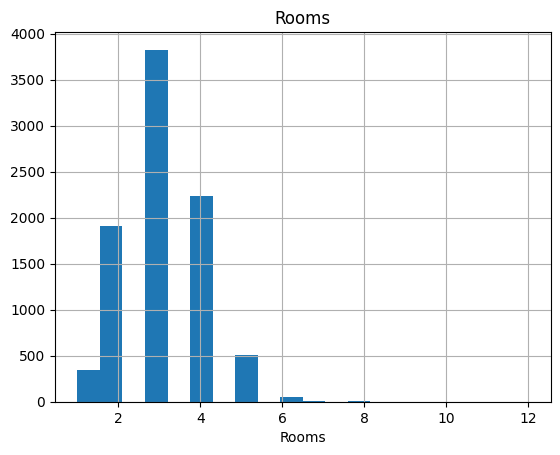

count      8887.000
mean    1092901.629
std      679381.904
min      131000.000
5%       417650.000
10%      490000.000
20%      600000.000
30%      690000.000
40%      790000.000
50%      900000.000
60%     1050000.000
70%     1250000.000
80%     1479800.000
90%     1900000.000
95%     2370700.000
99%     3550000.000
max     9000000.000
Name: Price, dtype: float64


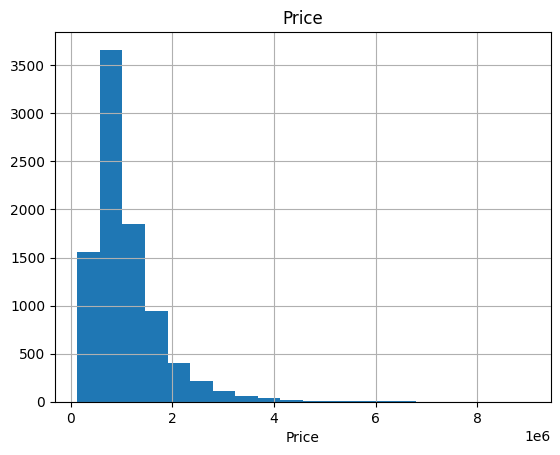

count   8887.000
mean      11.200
std        6.813
min        0.000
5%         2.600
10%        4.200
20%        5.900
30%        7.200
40%        8.400
50%       10.200
60%       11.400
70%       13.400
80%       14.700
90%       19.900
95%       24.700
99%       35.400
max       47.400
Name: Distance, dtype: float64


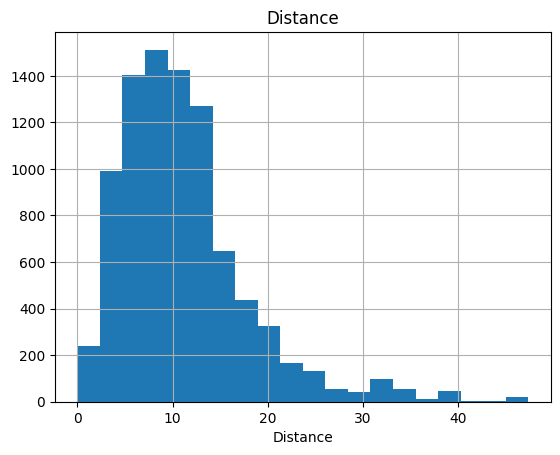

count   8887.000
mean    3111.663
std      112.614
min     3000.000
5%      3013.000
10%     3020.000
20%     3039.000
30%     3054.000
40%     3070.000
50%     3084.000
60%     3121.000
70%     3143.000
80%     3166.000
90%     3189.000
95%     3205.000
99%     3754.000
max     3977.000
Name: Postcode, dtype: float64


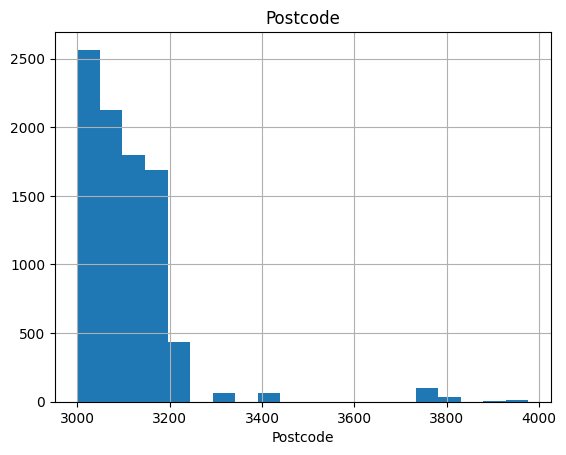

count   8887.000
mean       3.078
std        0.966
min        0.000
5%         2.000
10%        2.000
20%        2.000
30%        3.000
40%        3.000
50%        3.000
60%        3.000
70%        4.000
80%        4.000
90%        4.000
95%        5.000
99%        5.000
max       12.000
Name: Bedroom2, dtype: float64


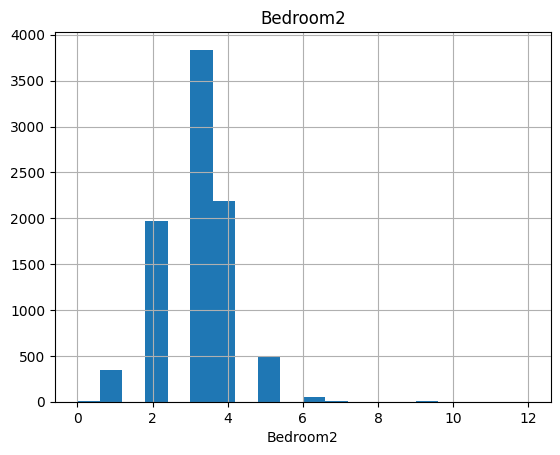

count   8887.000
mean       1.646
std        0.722
min        1.000
5%         1.000
10%        1.000
20%        1.000
30%        1.000
40%        1.000
50%        2.000
60%        2.000
70%        2.000
80%        2.000
90%        2.000
95%        3.000
99%        4.000
max        9.000
Name: Bathroom, dtype: float64


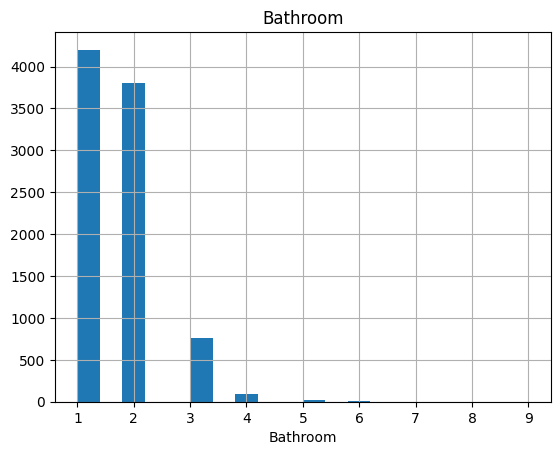

count   8887.000
mean       1.692
std        0.975
min        0.000
5%         0.000
10%        1.000
20%        1.000
30%        1.000
40%        1.000
50%        2.000
60%        2.000
70%        2.000
80%        2.000
90%        3.000
95%        4.000
99%        5.000
max       10.000
Name: Car, dtype: float64


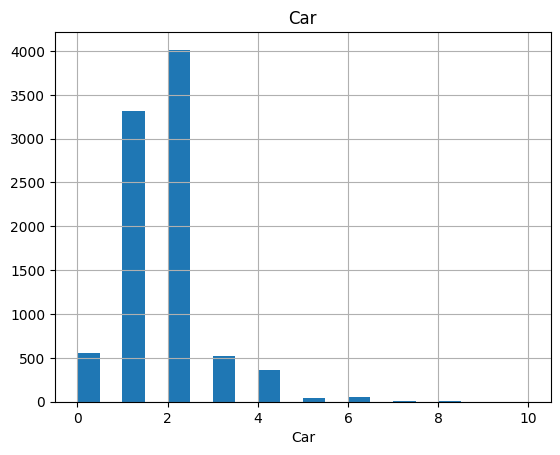

count    8887.000
mean      523.480
std      1061.324
min         0.000
5%          0.000
10%         0.000
20%       166.200
30%       260.000
40%       357.000
50%       478.000
60%       566.000
70%       619.000
80%       688.000
90%       794.000
95%       951.000
99%      2573.940
max     42800.000
Name: Landsize, dtype: float64


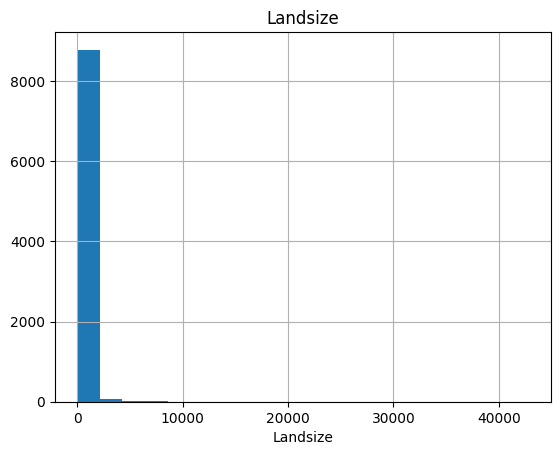

count   8887.000
mean     149.309
std       87.926
min        0.000
5%        57.000
10%       72.000
20%       92.000
30%      106.000
40%      119.000
50%      132.000
60%      148.000
70%      168.000
80%      195.077
90%      244.000
95%      296.000
99%      426.140
max     3112.000
Name: BuildingArea, dtype: float64


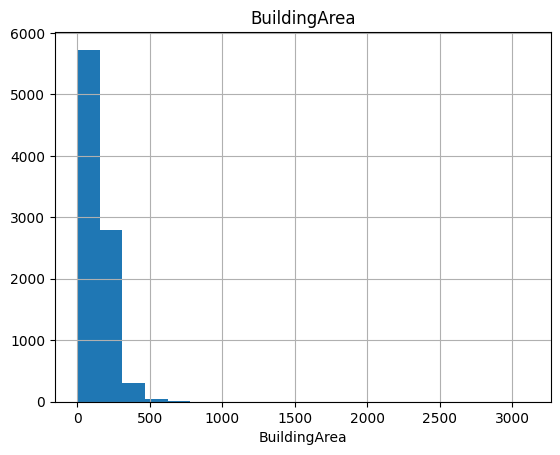

count   8887.000
mean    1965.753
std       37.041
min     1196.000
5%      1900.000
10%     1910.000
20%     1930.000
30%     1950.000
40%     1960.000
50%     1970.000
60%     1980.000
70%     1992.000
80%     2003.000
90%     2010.000
95%     2013.000
99%     2016.000
max     2019.000
Name: YearBuilt, dtype: float64


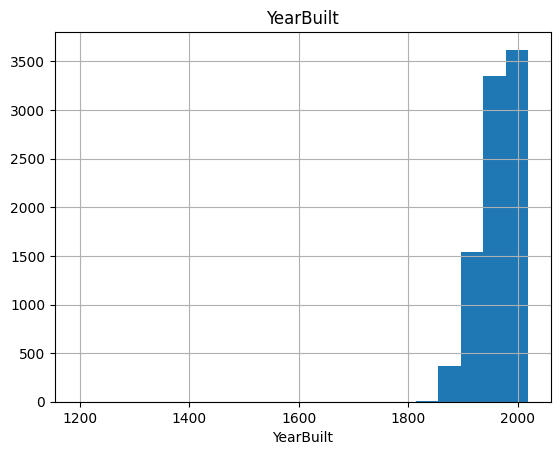

count   8887.000
mean     -37.805
std        0.091
min      -38.174
5%       -37.942
10%      -37.914
20%      -37.874
30%      -37.846
40%      -37.822
50%      -37.799
60%      -37.780
70%      -37.760
80%      -37.736
90%      -37.703
95%      -37.667
99%      -37.582
max      -37.407
Name: Lattitude, dtype: float64


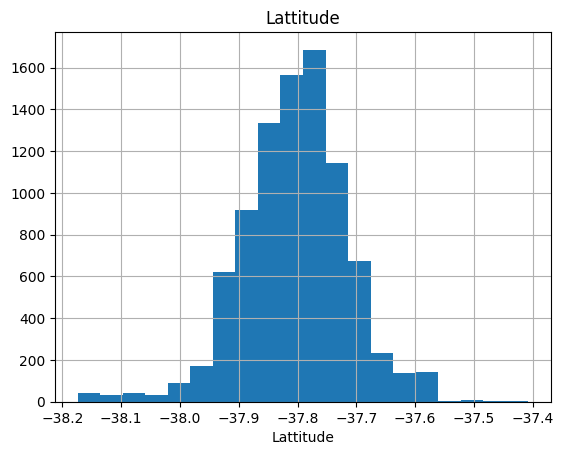

count   8887.000
mean     144.991
std        0.119
min      144.424
5%       144.795
10%      144.867
20%      144.899
30%      144.938
40%      144.973
50%      144.999
60%      145.021
70%      145.050
80%      145.080
90%      145.124
95%      145.172
99%      145.287
max      145.526
Name: Longtitude, dtype: float64


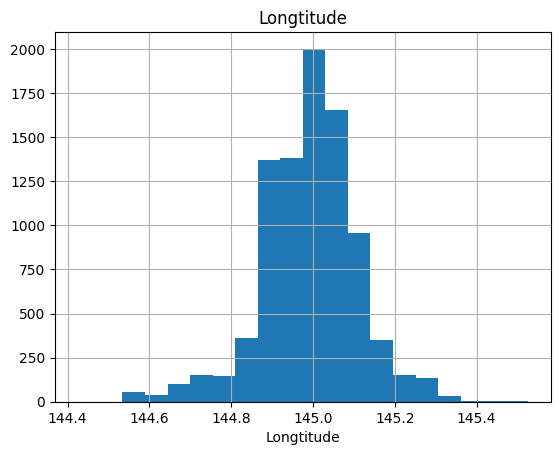

count    8887.000
mean     7475.940
std      4375.024
min       249.000
5%       2019.000
10%      2651.000
20%      3593.000
30%      4864.000
40%      5549.000
50%      6567.000
60%      7717.000
70%      8920.000
80%     10969.000
90%     14092.000
95%     15510.000
99%     21650.000
max     21650.000
Name: Propertycount, dtype: float64


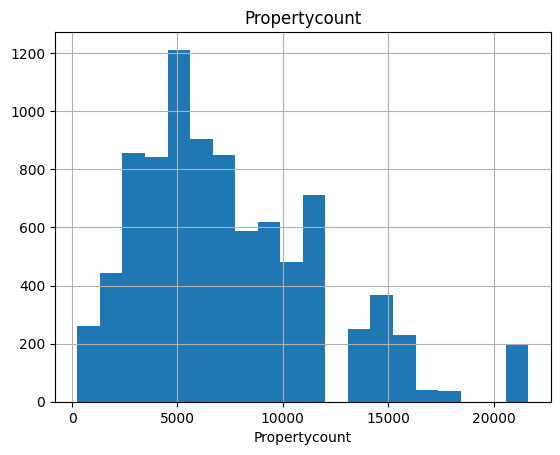

In [108]:
for col in num_cols:
    num_summary(df, col, plot=True)

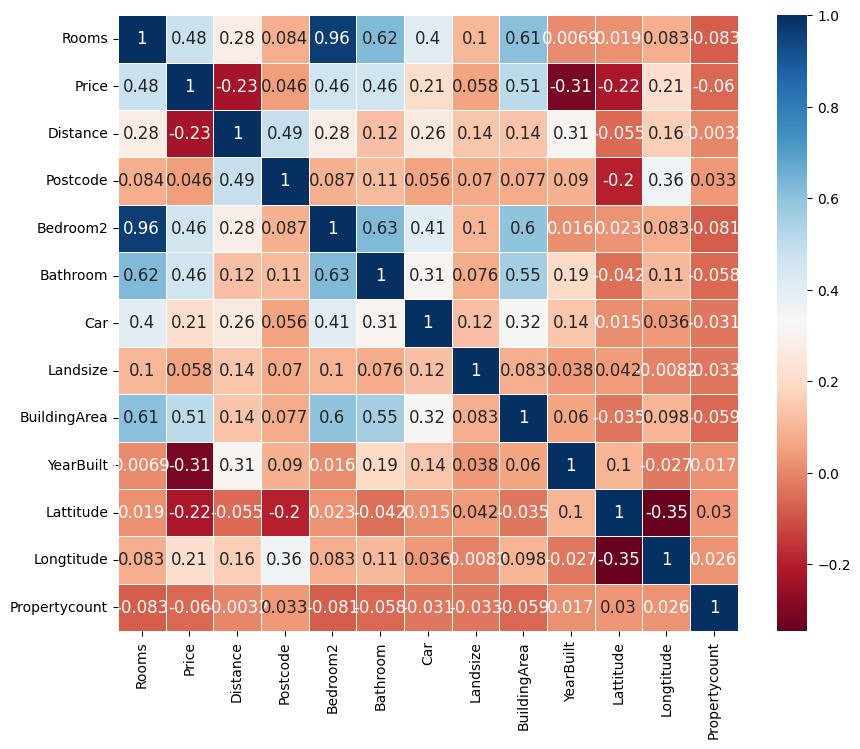

In [109]:
correlation_matrix(df,num_cols)

In [110]:
df.columns = [col.upper() for col in df.columns]

In [111]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 8887
Variables: 21
cat_cols: 4
num_cols: 12
cat_but_car: 5
num_but_cat: 1


In [112]:
num_cols = [col for col in num_cols if "PRİCE" not in col]

In [113]:
df = one_hot_encoder(df, cat_cols, drop_first=True)
df *= 1

In [114]:
df.columns = [col.upper() for col in df.columns]

In [115]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if "PRICE" not in col]
num_cols = [col for col in num_cols if "BEDROOM2" not in col]

Observations: 8887
Variables: 38
cat_cols: 21
num_cols: 12
cat_but_car: 5
num_but_cat: 21


In [116]:
df.head()

,SUBURB,ADDRESS,ROOMS,PRICE,SELLERG,DATE,DISTANCE,POSTCODE,BEDROOM2,CAR,LANDSIZE,BUILDINGAREA,YEARBUILT,COUNCILAREA,LATTITUDE,LONGTITUDE,PROPERTYCOUNT,TYPE_T,TYPE_U,METHOD_S,METHOD_SA,METHOD_SP,METHOD_VB,REGIONNAME_EASTERN VICTORIA,REGIONNAME_NORTHERN METROPOLITAN,REGIONNAME_NORTHERN VICTORIA,REGIONNAME_SOUTH-EASTERN METROPOLITAN,REGIONNAME_SOUTHERN METROPOLITAN,REGIONNAME_WESTERN METROPOLITAN,REGIONNAME_WESTERN VICTORIA,BATHROOM_2.0,BATHROOM_3.0,BATHROOM_4.0,BATHROOM_5.0,BATHROOM_6.0,BATHROOM_7.0,BATHROOM_8.0,BATHROOM_9.0
0,Abbotsford,25 Bloomburg St,2,1035000.000,Biggin,4/02/2016,2.500,3067.000,2.000,0.000,156.000,79.000,1900.000,Yarra City Council,-37.808,144.993,4019.000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Abbotsford,5 Charles St,3,1465000.000,Biggin,4/03/2017,2.500,3067.000,3.000,0.000,134.000,150.000,1900.000,Yarra City Council,-37.809,144.994,4019.000,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,Abbotsford,55a Park St,4,1600000.000,Nelson,4/06/2016,2.500,3067.000,3.000,2.000,120.000,142.000,2014.000,Yarra City Council,-37.807,144.994,4019.000,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Abbotsford,124 Yarra St,3,1876000.000,Nelson,7/05/2016,2.500,3067.000,4.000,0.000,245.000,210.000,1910.000,Yarra City Council,-37.802,144.999,4019.000,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,Abbotsford,98 Charles St,2,1636000.000,Nelson,8/10/2016,2.500,3067.000,2.000,2.000,256.000,107.000,1890.000,Yarra City Council,-37.806,144.995,4019.000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [117]:
drop = ["BEDROOM2","PRICE",'SUBURB', 'ADDRESS', 'SELLERG', 'DATE', 'COUNCILAREA']

In [118]:
X,y = df.drop(columns=drop), df["PRICE"] 

In [119]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [120]:
df["CAR"].value_counts()

CAR
2.000     4014
1.000     3318
0.000      553
3.000      523
4.000      366
6.000       50
5.000       47
7.000        8
8.000        5
10.000       2
9.000        1
Name: count, dtype: int64

In [121]:
def base_models(X, y, cv = 5, scoring="r2"):
    print("Base Models....")
    classifiers = [
        ("Gradient Boosting Regressor", GradientBoostingRegressor()),
        ("XGB Regressor", XGBRegressor()),
        ("Decision Tree Regressor", DecisionTreeRegressor()),
        ("Random Forest Regressor", RandomForestRegressor()),
        ("Linear Regression", LinearRegression()),
        ("Lasso Regression", Lasso())
    ]

    best_score = float("-inf")
    best_model_name = ""
    best_model = None

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)
        mean_score = cv_results['test_score'].mean()
        print(f"{scoring}: {round(mean_score, 4)} ({name}) ")

        if mean_score > best_score:
            best_score = mean_score
            best_model_name = name
            best_model = classifier

    print(f"\nModel with the highest {scoring} value: {best_model_name} ({best_score:.4f})")

    y_pred = cross_val_predict(best_model, X, y, cv=cv)

    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y,y_pred)

    print("\nEvaluation metrics:")
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("r2:", r2)


In [122]:
base_models(X, y, scoring="r2")

Base Models....


r2: 0.7837 (Gradient Boosting Regressor) 
r2: 0.8039 (XGB Regressor) 
r2: 0.6042 (Decision Tree Regressor) 
r2: 0.7901 (Random Forest Regressor) 
r2: -17.3088 (Linear Regression) 
r2: 0.63 (Lasso Regression) 

Model with the highest r2 value: XGB Regressor (0.8039)

Evaluation metrics:
Mean Absolute Error (MAE): 172605.45610688365
Mean Squared Error (MSE): 88928937080.52261
r2: 0.8073078498077559


In [124]:

Gradient_Boosting_params = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }

XGB_Regressor_params = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }

Decision_Tree_params = {
        'max_depth': [3, 4, 5, None]
    }

Random_Forest_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5, None]
    }

Lasso_Regression_params = {
    'alpha': [0.1, 1.0, 10.0]
    }

Linear_Regression_params = {}

classifiers = [
        ("Gradient Boosting Regressor", GradientBoostingRegressor(), Gradient_Boosting_params),
        ("XGB Regressor", XGBRegressor(), XGB_Regressor_params),
        ("Decision Tree Regressor", DecisionTreeRegressor(), Decision_Tree_params),
        ("Random Forest Regressor", RandomForestRegressor(), Random_Forest_params,),
        ("Linear Regression", LinearRegression(), Linear_Regression_params),
        ("Lasso Regression", Lasso(), Lasso_Regression_params)
        ]



In [125]:
def hyperparameter_optimization(X, y, cv=5, scoring="r2"):
    print("Hyperparameter Optimization....")
    best_models = {}
    best_score = float("-inf")
    best_model_name = ""
    
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        mean_score = round(cv_results['test_score'].mean(), 4)
        print(f"{scoring} (After): {mean_score}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

        if mean_score > best_score:
            best_score = mean_score
            best_model_name = name
            best_model = final_model

    print(f"\nModel with the highest {scoring} value: {best_model_name} ({best_score:.4f})")

    y_pred = cross_val_predict(best_model, X, y, cv=cv)

    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y,y_pred)

    print("\nEvaluation metrics:")
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("r2:", r2)

    return best_models


In [126]:
hyperparameter_optimization(X, y, cv=5, scoring="r2")

Hyperparameter Optimization....
########## Gradient Boosting Regressor ##########
r2 (Before): 0.7837
r2 (After): 0.818
Gradient Boosting Regressor best params: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300}

########## XGB Regressor ##########
r2 (Before): 0.8039
r2 (After): 0.8204
XGB Regressor best params: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}

########## Decision Tree Regressor ##########
r2 (Before): 0.5664
r2 (After): 0.6272
Decision Tree Regressor best params: {'max_depth': 5}

########## Random Forest Regressor ##########
r2 (Before): 0.7915
r2 (After): 0.7949
Random Forest Regressor best params: {'max_depth': None, 'n_estimators': 300}

########## Linear Regression ##########
r2 (Before): -17.3088
r2 (After): -17.3088
Linear Regression best params: {}

########## Lasso Regression ##########
r2 (Before): 0.63
r2 (After): 0.63
Lasso Regression best params: {'alpha': 10.0}


Model with the highest r2 value: XGB Regressor (0.8204)

Evaluation met

{}